<a href="https://colab.research.google.com/github/al34n1x/DataScience/blob/master/99.Machine_Learning/16_Clustering_de_Series_Temporales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Comparación Clustering

Tomado de [SciKit Learn](https://scikit-learn.org/stable/modules/clustering.html)

Automatically created module for IPython interactive environment


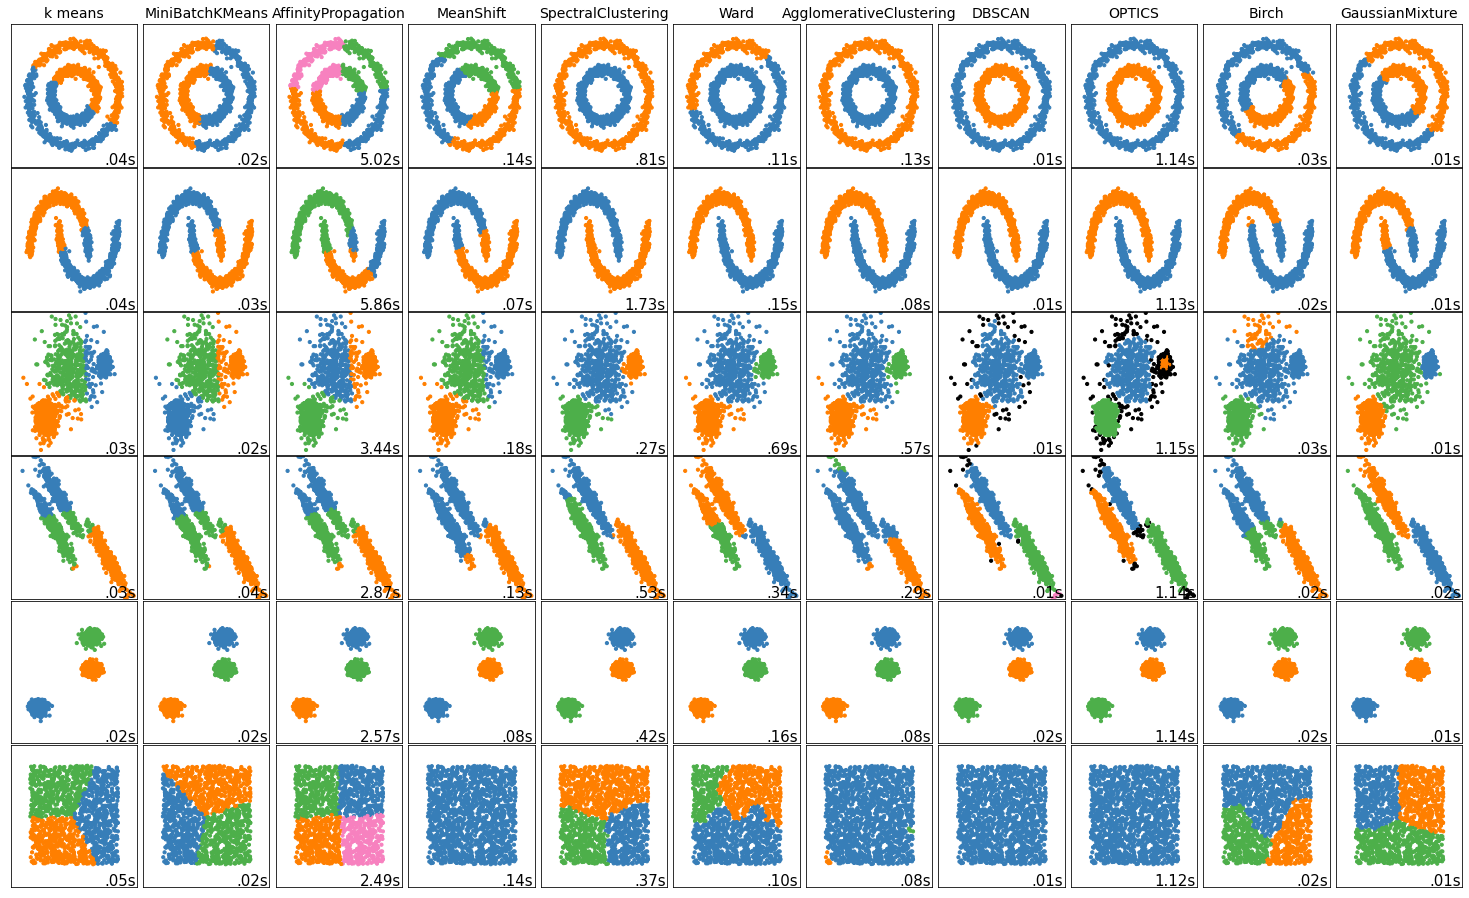

In [ ]:
print(__doc__)

import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=((9 * 2 + 3), 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3,
                'min_samples': 20,
                'xi': 0.05,
                'min_cluster_size': 0.1}

datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2,
                     'min_samples': 20, 'xi': 0.25}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2,
              'min_samples': 5, 'xi': 0.035, 'min_cluster_size': .2}),
    (aniso, {'eps': .15, 'n_neighbors': 2,
             'min_samples': 20, 'xi': 0.1, 'min_cluster_size': .2}),
    (blobs, {}),
    (no_structure, {})]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward',
        connectivity=connectivity)
    spectral = cluster.SpectralClustering(
        n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=params['eps'])
    optics = cluster.OPTICS(min_samples=params['min_samples'],
                            xi=params['xi'],
                            min_cluster_size=params['min_cluster_size'])
    affinity_propagation = cluster.AffinityPropagation(
        damping=params['damping'], preference=params['preference'])
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock",
        n_clusters=params['n_clusters'], connectivity=connectivity)
    birch = cluster.Birch(n_clusters=params['n_clusters'])
    gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'], covariance_type='full')
    k_means = cluster.KMeans(n_clusters=params['n_clusters'])

    clustering_algorithms = (
        ('k means', k_means),
        ('MiniBatchKMeans', two_means),
        ('AffinityPropagation', affinity_propagation),
        ('MeanShift', ms),
        ('SpectralClustering', spectral),
        ('Ward', ward),
        ('AgglomerativeClustering', average_linkage),
        ('DBSCAN', dbscan),
        ('OPTICS', optics),
        ('Birch', birch),
        ('GaussianMixture', gmm)
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=14)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()

In [ ]:
import pandas as pd
import pandas_datareader as web 
import datetime
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


# Introducción



*   El clustering o agrupamiento de series temporales consiste en su particionado en grupos a partir de alguna medida de distancia o similitud entre ellas.
*   La comparación entre dos series temporales es un problema importante en la minería de datos que persigue la determinación del grado de similitud entre dos series temporales.
*   Existen una gran cantidad de enfoques que permiten comparar dos series temporales.
>* Comparar las series temporales completas
>* Emplear características de las series para compararlas.
>* Utilizar transformaciones matemáticas sobre las series y realizar la comparación con las versiones transformadas. t.


# Estrategias para la clusterizaciónde series temporales



* Series completas:
>Dado un conjunto de N series de longitud T, se puede considerar cada serie temporal como un punto en un espacio T dimensional, definir una distancia para cada par de puntos y aplicar el algoritmo de agrupación sobre la nube de los N puntos.
*  Series caracterizadas:
>Se resume cada serie en un conjunto de parámetros, correspondiente a características de la serie. Así la agrupación se realizar sobre la información extraída de la serie.
*  Series transformadas:
>Se emplean transformadas matemáticas como la DiscreteWavelet Transform(DWT) o la DiscreteFourier Transform(DFT) para calcular la similitud entre series.
*  En todos los casos, el objetivo de la clusterizaciónde series temporales es encontrar una agrupación que:
>* Minimice las distancias entrelasseriesen un mismo grupo.
>* Maximice las distancias entre series en distintos grupos.
* Algunos de los posibles algoritmos a aplicar son K-means, el clustering jerárquico o el clustering basado en densidad.
* Estos algoritmos se pueden aplicar siguiendo diferentes criterios:
>* De distancia entra las series: Euclídea, DTW. …
>* De similitud entre las series: Autocorrelación, Transformadas(DFT, DWT), estadísticosde las series (Min, max, media, mediana, quartiles…).


# Algoritmos de clusterización utilizados
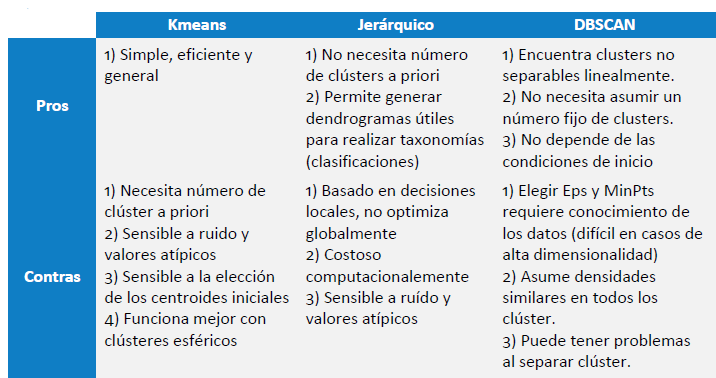

# Distancia euclidea

* La distancia euclídea es una de las más comunes:

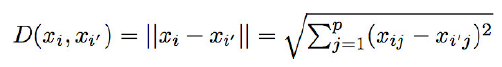

* Los clústeres definidos por la distancia euclídea son invariantes a traslaciones y rotaciones en el espacio de características pero no al escalado de características
* Se puede estandarizar los datos de forma que tengan media 0 y varianza 1.
* Solo definidos para series con la misma cantidad de muestras.
* Sensible al ruido, el escalado y los desplazamientos temporales.
> ¡¡¡No siempre es adecuado!!!!

# Alineamiento Temporal Dinámico (DTW, Dynamic time warping)

* DTW (Dynamic Time Warping) encuentra el alineamiento no lineal óptimo entre dos series temporales. A la hora de comparar series, la DTW permite comprimir y alargarelejetemporalparaintentarbuscarunmejorajustedelasseriestemporales.
>* La distancia euclídeaentre alineamientos es mucho menos susceptible a medidas pesimistas de similituddebido a la distorsión del eje temporal.
>* Alto costecomputacional ya que es cuadrática con la duración de las series temporales.
* Las técnicas basadas en la idea de STW permiten comparar series temporales cuando éstas tienen una escala temporal diferente.
* Una de las aplicaciones habituales de la DTW es el reconocimiento de voz.

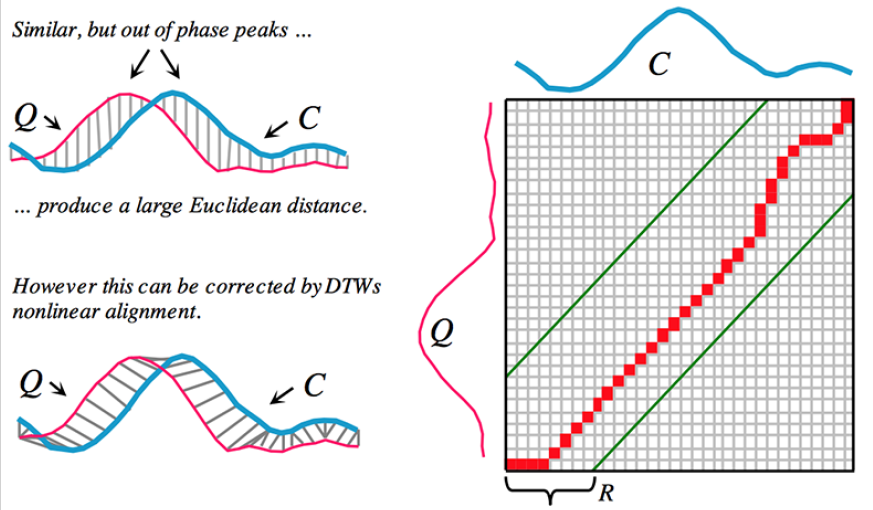

# Recolección y procesado de datos
Obtenemos los valores de cierre ('Close') de las acciones para las empresas que nos interesa. Se cubre el periodo comprendido entre el 1 de enero de 2015 y la fecha actual.

In [ ]:
start = datetime.datetime(2019, 1, 1)
end = datetime.date.today()
prices = []

ticker_list = {
    'PAM' : 'Pampa Energ', 'GGAL' : 'GF Galicia', 'SUPV' : 'Supervielle','BMA' : 'Banco Macro',
    'TX' : 'Ternium' , 'NFLX' : 'Netflix', 'ZM' : 'Zoom',
    'YPF' : 'YPF', 'TEO' : 'Telecom', 'AZN' : 'AstraZeneca', 'DAL' : 'Delta',
    'AAL' : 'American Airlines' , 'UAL' : 'United Airlines' , 
    'INTC': 'Intel','MSFT': 'Microsoft','IBM': 'IBM','AAPL': 'Apple','AMZN': 'Amazon',
    'QCOM': 'Qualcomm','GOOG': 'Google','CSCO': 'Cisco Systems','EA': 'Electronic Arts',
    'FB': 'Facebook', 'T' : 'AT&T','NVDA': 'NVDIA', 'TRIP' : 'Trip Advisor', 'V' : 'Visa', 
    'MELI' : 'MELI' , 'TSLA' : 'Tesla', 'BBAR' : 'BBVA_Arg'}


for ticker in ticker_list:
    currentClosePrices = web.DataReader(ticker,'yahoo',start,end)['Close']
    currentClosePrices.name = ticker
    prices.append(currentClosePrices)


Se convierten los valores obtenidos en un DF y se rellenan los NA con ceros.

In [ ]:
prices = pd.DataFrame(prices)
if prices.isnull().values.any():
    prices = prices.fillna(0)
prices.head(20)

Date,2019-01-02,2019-01-03,2019-01-04,2019-01-07,2019-01-08,2019-01-09,2019-01-10,2019-01-11,2019-01-14,2019-01-15,2019-01-16,2019-01-17,2019-01-18,2019-01-22,2019-01-23,2019-01-24,2019-01-25,2019-01-28,2019-01-29,2019-01-30,2019-01-31,2019-02-01,2019-02-04,2019-02-05,2019-02-06,2019-02-07,2019-02-08,2019-02-11,2019-02-12,2019-02-13,2019-02-14,2019-02-15,2019-02-19,2019-02-20,2019-02-21,2019-02-22,2019-02-25,2019-02-26,2019-02-27,2019-02-28,...,2020-07-13,2020-07-14,2020-07-15,2020-07-16,2020-07-17,2020-07-20,2020-07-21,2020-07-22,2020-07-23,2020-07-24,2020-07-27,2020-07-28,2020-07-29,2020-07-30,2020-07-31,2020-08-03,2020-08-04,2020-08-05,2020-08-06,2020-08-07,2020-08-10,2020-08-11,2020-08-12,2020-08-13,2020-08-14,2020-08-17,2020-08-18,2020-08-19,2020-08-20,2020-08-21,2020-08-24,2020-08-25,2020-08-26,2020-08-27,2020-08-28,2020-08-31,2020-09-01,2020-09-02,2020-09-03,2020-09-04
PAM,33.299999,33.410000,35.349998,35.810001,36.490002,36.959999,35.799999,36.400002,35.790001,36.009998,35.919998,35.349998,35.770000,34.970001,34.980000,35.610001,34.580002,34.619999,35.090000,35.150002,35.650002,35.730000,35.630001,36.990002,36.970001,36.200001,37.090000,38.549999,38.549999,38.029999,37.820000,37.200001,34.709999,34.549999,33.820000,34.419998,33.759998,33.709999,32.880001,31.860001,...,11.500000,11.480000,11.690000,11.460000,11.050000,11.020000,11.580000,12.300000,12.290000,12.280000,12.040000,11.520000,11.420000,11.160000,10.940000,12.140000,12.230000,11.620000,11.590000,11.530000,11.230000,11.020000,10.550000,11.000000,11.150000,10.780000,10.880000,10.890000,10.910000,10.990000,11.030000,11.190000,11.440000,11.510000,11.990000,11.490000,11.780000,11.760000,11.910000,11.960000
GGAL,28.480000,28.680000,30.700001,31.240000,31.459999,32.369999,33.439999,32.490002,32.090000,31.799999,31.540001,31.760000,33.209999,32.480000,33.779999,33.509998,34.340000,34.790001,34.750000,35.560001,36.509998,36.180000,37.060001,37.299999,35.490002,35.200001,35.990002,36.320000,36.759998,35.200001,35.419998,34.779999,32.610001,33.000000,32.419998,33.669998,33.459999,33.029999,31.639999,30.570000,...,11.340000,11.270000,11.680000,11.510000,11.230000,10.890000,11.360000,12.300000,12.470000,12.470000,12.770000,12.220000,12.320000,12.120000,12.000000,13.270000,13.050000,12.650000,12.690000,12.850000,12.440000,11.860000,11.460000,11.530000,11.370000,10.790000,10.660000,10.370000,10.250000,10.110000,10.060000,10.170000,10.040000,9.900000,10.600000,10.330000,10.400000,10.110000,10.280000,10.180000
SUPV,8.490000,8.540000,8.900000,8.880000,8.920000,9.300000,9.480000,9.650000,9.410000,9.380000,9.200000,9.200000,9.460000,9.160000,9.370000,9.240000,9.440000,9.790000,9.910000,10.290000,10.490000,10.710000,11.300000,11.310000,10.760000,10.630000,10.790000,10.820000,11.020000,10.580000,10.820000,10.630000,9.970000,9.680000,9.400000,10.040000,9.630000,9.590000,9.130000,8.920000,...,2.520000,2.590000,2.650000,2.590000,2.700000,2.560000,2.750000,2.950000,2.980000,2.940000,3.010000,2.950000,2.990000,2.980000,2.880000,3.230000,3.180000,2.990000,2.950000,2.930000,2.880000,2.700000,2.640000,2.680000,2.610000,2.560000,2.540000,2.470000,2.560000,2.520000,2.440000,2.440000,2.420000,2.420000,2.680000,2.570000,2.620000,2.560000,2.560000,2.510000
BMA,43.869999,44.360001,46.900002,50.009998,49.500000,50.570000,52.349998,53.169998,53.000000,52.750000,49.950001,51.660000,53.830002,52.730000,54.970001,53.980000,55.000000,55.250000,56.709999,57.150002,57.869999,57.980000,59.720001,59.680000,57.330002,56.880001,57.439999,57.619999,59.029999,56.820000,58.110001,56.950001,52.000000,51.049999,51.669998,54.080002,52.270000,53.410000,52.209999,50.500000,...,21.660000,21.450001,22.510000,21.980000,21.430000,20.660000,21.510000,23.230000,23.430000,23.530001,23.900000,22.820000,23.049999,21.959999,21.280001,23.480000,23.230000,22.320000,22.170000,22.280001,21.950001,20.760000,19.680000,20.200001,20.240000,19.100000,18.900000,18.629999,18.440001,18.219999,18.360001,18.580000,18.330000,17.879999,19.1

Trasposición de las matriz de precios de las acciones 

In [ ]:
transposePrices = prices.transpose()
transposePrices.head()

,PAM,GGAL,SUPV,BMA,TX,NFLX,ZM,YPF,TEO,AZN,DAL,AAL,UAL,INTC,MSFT,IBM,AAPL,AMZN,QCOM,GOOG,CSCO,EA,FB,T,NVDA,TRIP,V,MELI,TSLA,BBAR
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-02,33.299999,28.480000,8.49,43.869999,27.670000,267.660004,0.0,13.72,15.31,37.799999,50.090000,32.480000,84.180000,47.080002,101.120003,115.209999,39.480000,1539.130005,57.400002,1045.849976,42.950001,80.370003,135.679993,29.540001,136.220001,54.220001,132.919998,298.010010,62.023998,11.24
2019-01-03,33.410000,28.680000,8.54,44.360001,27.090000,271.200012,0.0,13.76,14.79,38.330002,45.610001,30.059999,80.000000,44.490002,97.400002,112.910004,35.547501,1500.280029,55.700001,1016.059998,41.070000,78.709999,131.740005,29.580000,127.989998,51.040001,128.130005,296.589996,60.071999,11.41
2019-01-04,35.349998,30.700001,8.90,46.900002,28.200001,297.570007,0.0,14.43,15.19,39.180000,47.790001,32.040001,82.680000,47.220001,101.930000,117.320000,37.064999,1575.390015,56.599998,1070.709961,42.919998,84.419998,137.949997,30.340000,136.190002,53.919998,133.649994,315.329987,63.537998,11.85
2019-01-07,35.810001,31.240000,8.88,50.009998,28.280001,315.339996,0.0,14.53,14.95,38.779999,47.849998,32.950001,83.230003,47.439999,102.059998,118.150002,36.982498,1629.510010,56.439999,1068.390015,43.209999,87.589996,138.050003,30.889999,143.399994,55.240002,136.059998,328.940002,66.991997,12.22
2019-01-08,36.490002,31.459999,8.92,49.500000,28.709999,320.269989,0.0,14.23,15.23,38.130001,47.470001,32.419998,82.379997,47.740002,102.800003,119.830002,37.687500,1656.579956,55.950001,1076.280029,43.560001,89.019997,142.529999,31.280001,139.830002,57.169998,136.800003,328.489990,67.070000,12.30


In [ ]:
####### PLACEHOLDER

In [ ]:
transposePrices.mean()

PAM       19.297783
GGAL      18.410118
SUPV       4.422606
BMA       35.418420
TX        20.615849
NFLX     366.087688
ZM       105.599575
YPF       10.355731
TEO       11.793349
AZN       45.893019
DAL       46.984764
AAL       24.866274
UAL       69.520731
INTC      53.914835
MSFT     151.971321
IBM      132.535425
AAPL      65.176238
AMZN    2057.051014
QCOM      78.095354
GOOG    1275.979115
CSCO      47.982476
EA       105.332948
FB       196.092524
T         33.248797
NVDA     238.772453
TRIP      35.389434
V        175.928868
MELI     638.868090
TSLA     111.921344
BBAR       6.425283
dtype: float64

#Cálculo de la distancia DTW

In [ ]:
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
import time
distance = lambda column1, column2: fastdtw(column1, column2, dist=euclidean)
start = time.time()
results2 = transposePrices.apply(lambda col1: transposePrices.apply(lambda col2: distance(col1, col2)))
end = time.time()
timeDTW = end - start
timeDTW 

110.08045554161072


Inspección de la matriz de alineamiento

In [ ]:
results2.iloc[0:3,0:3]

,PAM,GGAL,SUPV
PAM,"(0.0, [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4),...","(464.29000759124756, [(0, 0), (1, 0), (2, 0), ...","(6108.184988975525, [(0, 0), (1, 1), (2, 2), (..."
GGAL,"(447.8700017929077, [(0, 0), (0, 1), (0, 2), (...","(0.0, [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4),...","(4977.57488822937, [(0, 0), (1, 1), (2, 2), (3..."
SUPV,"(6047.114980697632, [(0, 0), (1, 1), (2, 2), (...","(4665.074858665466, [(0, 0), (1, 1), (2, 2), (...","(0.0, [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4),..."


 
Normalización de las distancias 

In [ ]:
ldtw = len(results2)
dtw_distances = [[ results2[index1][index2][0] for index2 in results2.columns] for index1 in results2.columns]
dtw_distances = pd.DataFrame(dtw_distances)
dtw_distances=(dtw_distances/dtw_distances.max().max())
dtw_distances.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,0.000000,0.000515,0.006948,0.004406,0.001684,0.168949,0.047647,0.003659,0.002927,0.012928,0.008998,0.000898,0.019882,0.016865,0.064636,0.055167,0.022296,0.992753,0.028645,0.612230,0.013698,0.041915,0.086131,0.006014,0.106924,0.004175,0.076308,0.301842,0.045057,0.005063
1,0.000533,0.000000,0.005360,0.005033,0.001967,0.169382,0.047763,0.003292,0.002854,0.013232,0.010654,0.001118,0.020871,0.017297,0.065068,0.055600,0.022716,0.993186,0.029077,0.612663,0.014151,0.042347,0.086563,0.006126,0.107356,0.004871,0.076740,0.302275,0.045494,0.004338
2,0.007018,0.005719,0.000000,0.015101,0.007854,0.176196,0.050723,0.001395,0.002473,0.020204,0.020735,0.009717,0.031715,0.024112,0.071883,0.062414,0.029598,1.000000,0.035892,0.619477,0.021222,0.049162,0.093378,0.014044,0.114171,0.015086,0.083554,0.309089,0.052371,0.000626
3,0.004406,0.005022,0.015101,0.000000,0.005545,0.161096,0.041515,0.011597,0.010957,0.008481,0.003023,0.004779,0.008906,0.008913,0.056782,0.047313,0.017435,0.984899,0.018573,0.604377,0.005705,0.034061,0.078277,0.006383,0.099070,0.002106,0.068454,0.293989,0.039241,0.014125
4,0.001652,0.001947,0.007842,0.005520,0.000000,0.168307,0.046304,0.003658,0.003135,0.012315,0.010053,0.001157,0.021522,0.016223,0.063994,0.054525,0.021709,0.992111,0.028003,0.611588,0.013332,0.041272,0.085489,0.005744,0.106282,0.004597,0.075665,0.301200,0.044482,0.006325


# KMeans

## Número de clústeres con Kmeans (todas las muestras)

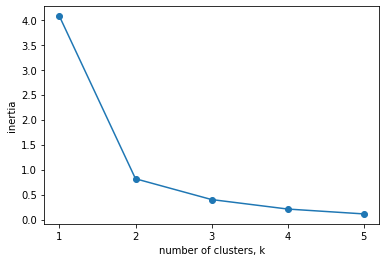

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer 
from sklearn.cluster import KMeans

ks = range(1,6)
inertias = []
for k in ks:
# Crea una función de normalizador
    normalizer = Normalizer()
# Genera un modelo para KMeans con k clústeres
    kmeans = KMeans(k)
# Crea un pipeline encadenando 'normalizer' y 'kmeans'
    pipeline = make_pipeline(normalizer,kmeans)
# Ajusta el modelo a las muestras
    pipeline.fit(dtw_distances)
# Agrega las inercias calculadas
    inertias.append(kmeans.inertia_) 
# Gráfico de inercias vs. número de clusters
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()


In [ ]:
companies = list(ticker_list.keys())

numClusters = 3

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer 
from sklearn.cluster import KMeans

# Instancia el Normalizador
normalizer = Normalizer()

# Instancia KMeans
kmeans = KMeans(n_clusters=numClusters)

# Crea una cadena de procesado
pipeline = make_pipeline(normalizer,kmeans)

# Adapta el pipeline a las muestras de entrada
pipeline.fit(dtw_distances)


# Predice las etiquetas
k_means_labels = pipeline.predict(dtw_distances)

# Se crea un DF para alinear etiquetas ('labels') y empresas 
df = pd.DataFrame({'labels': k_means_labels, 'companies': companies})



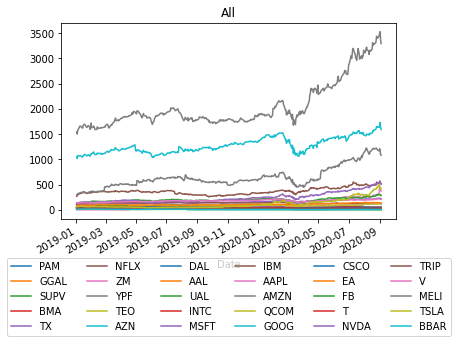

In [ ]:
prices.transpose().plot()
plt.legend(bbox_to_anchor=(0.5,-0.2), borderaxespad=0.,loc=9, ncol=6)
plt.title(r"All")
plt.show()


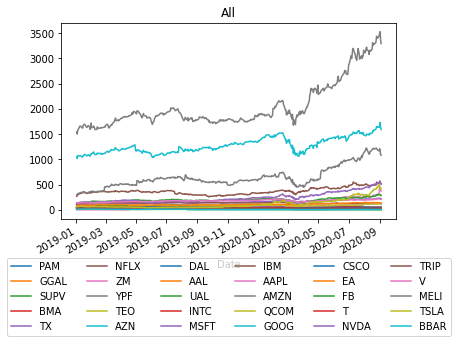

In [ ]:
transposePrices.plot()
plt.legend(bbox_to_anchor=(0.5,-0.2), borderaxespad=0.,loc=9, ncol=6)
plt.title(r"All")
plt.show()

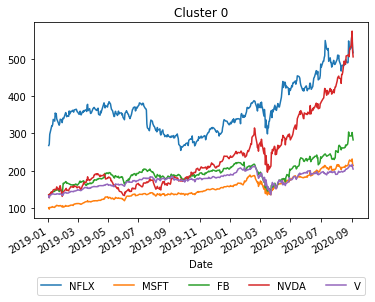

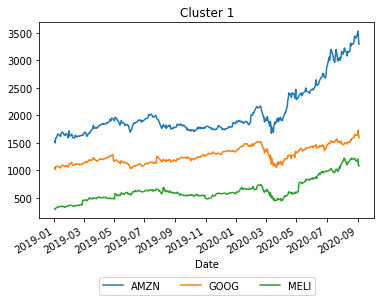

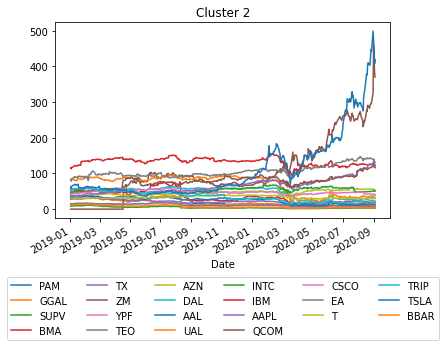

In [ ]:
for index in range(0,numClusters):
    prices.loc[df[k_means_labels == index]['companies']].transpose().plot()
    plt.legend(bbox_to_anchor=(0.5,-0.3), borderaxespad=0.,loc=9, ncol=6)
    plt.title(r"Cluster " + str(index))
    plt.show()



# Clustering jerárquico

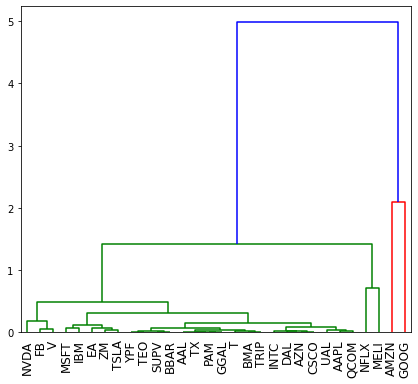

In [ ]:
from scipy.cluster.hierarchy import linkage , dendrogram 
import matplotlib.pyplot as plt

from  sklearn.preprocessing import normalize

# Obtiene tamaño actual de la figura
fig_size = plt.rcParams["figure.figsize"]

# Cambia el tamaño
fig_size[0] = 7
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size

# Calcula los uniones entre clústeres
mergings = linkage(dtw_distances,method='complete')

# Dibuja el dendrograma
dendrogram(mergings,
           labels=companies,
           leaf_rotation=90,
           leaf_font_size=12,
)
plt.show()


In [ ]:
plt.gcf()
plt.savefig("dendrogram_dtw.png")


<Figure size 504x432 with 0 Axes>

# Clustering Jerárquico

In [ ]:
# Se extraen los clúster siguiendo el criterio de distancia
from scipy.cluster.hierarchy import fcluster
max_d = 0.5 # 0.7
hierarchical_labels = fcluster(mergings, max_d, criterion='distance')
numClusters = len(set(hierarchical_labels))
hierarchical_labels


array([1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 5, 1, 1,
       1, 1, 1, 1, 1, 3, 1, 1], dtype=int32)

Cálculos basados en distancias

In [ ]:
# Se crea un DF para alinear etiquetas ('labels') y empresas 
df_hierarchical = pd.DataFrame({'labels': hierarchical_labels, 'companies': companies})


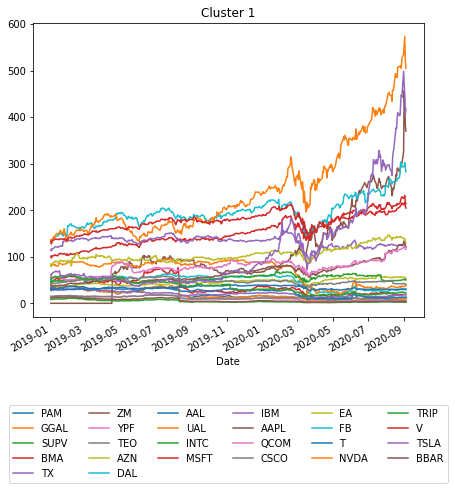

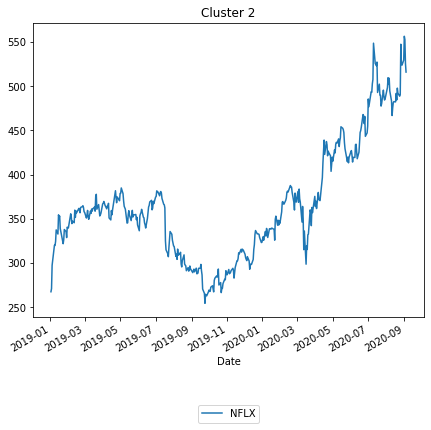

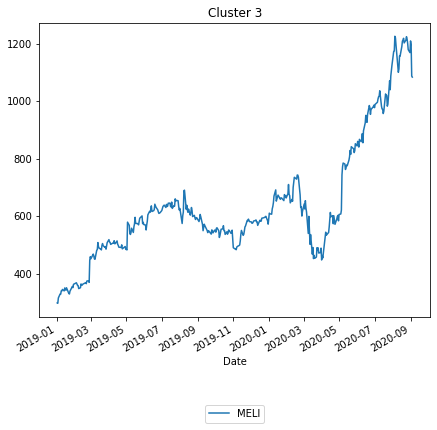

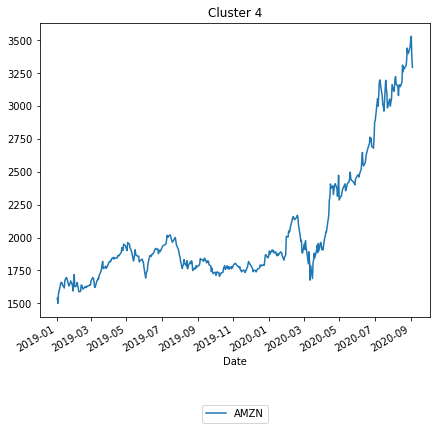

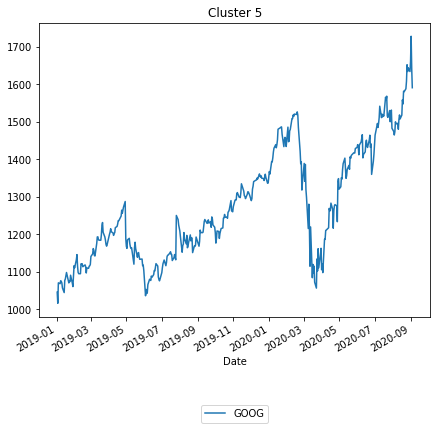

In [ ]:
for index in range(1,numClusters+1):
    prices.loc[df_hierarchical[hierarchical_labels == index]['companies']].transpose().plot()
    plt.legend(bbox_to_anchor=(0.5,-0.3), borderaxespad=0.,loc=9, ncol=6)
    plt.title(r"Cluster " + str(index))
    plt.show()


# DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

db = DBSCAN(eps=0.5, min_samples=2).fit(dtw_distances)  #modificar epsilon
dbscan_labels = db.labels_
# Se crea un DF para alinear etiquetas ('labels') y empresas 
df_dbscan = pd.DataFrame({'labels': dbscan_labels, 'companies': companies})
numClusters = len(set(dbscan_labels))
minCluster = min(set(dbscan_labels))
maxCluster = max(set(dbscan_labels))


In [ ]:

df_dbscan


,labels,companies
0,0,PAM
1,0,GGAL
2,0,SUPV
3,0,BMA
4,0,TX
5,0,NFLX
6,0,ZM
7,0,YPF
8,0,TEO
9,0,AZN


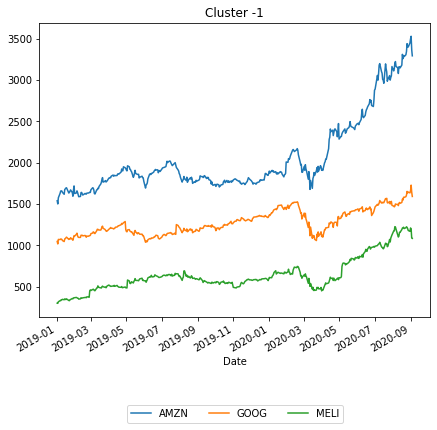

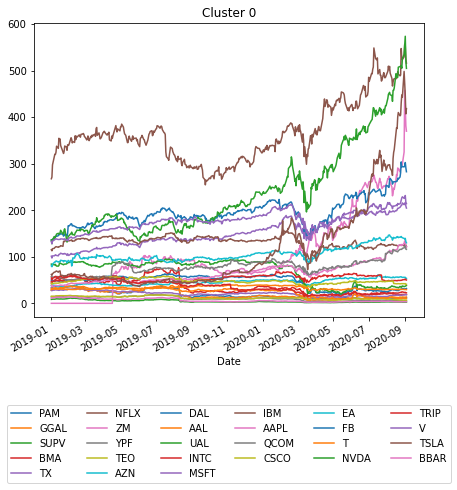

In [ ]:
for index in range(minCluster,maxCluster+1):
    prices.loc[df_dbscan[dbscan_labels == index]['companies']].transpose().plot()
    plt.legend(bbox_to_anchor=(0.5,-0.3), borderaxespad=0.,loc=9, ncol=6)
    plt.title(r"Cluster " + str(index))
    plt.show()
